# Trying Variations 1.0

### 1. Applying Transformations on the train and validation images for Data Augmentation and Data Normalization

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import sys
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [3]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import datetime
import os
import torchvision
import time
import copy
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [4]:
torch.__version__

'1.7.1+cu110'

In [5]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

In [6]:
# validate the training on validation set
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        print(name)
        print(loader)
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                y = model(imgs)
                _, predicted = torch.max(y, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.4f}".format(name, correct/total))
        print("{}: correct, total = {},{}".format(name, correct, total))

In [7]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history, val_loss_history = [], []
    train_acc_history, train_loss_history = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_train = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        loss_train += loss.item()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                
        # decreasing learning rate with the epochs
        scheduler.step(loss_train)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.layer1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 5,
                                stride = 2, padding = 2)
        self.layer2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, 
                               stride = 2, padding = 2)
        self.layer3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 5, 
                               stride = 2, padding = 2)
        self.mxpool = nn.MaxPool2d(2, 2)
        self.mxpool1 = nn.MaxPool2d(2, 2, padding = 1)
        self.relu = nn.ReLU() # not used # instead used relu from Functional 'F' directly
        self.linear1 = nn.Linear(256, 1024)
        self.linear2 = nn.Linear(1024, 1024)
        self.linear3 = nn.Linear(1024, 100)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.mxpool(x)
        x = F.relu(self.layer2(x))
        x = self.mxpool1(x)
        x = F.relu(self.layer3(x))
        x = self.mxpool(x)
        
        x = x.reshape(x.shape[0], -1)
#         print(x.shape)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x) # using nn.CrossEntropy() that combines nn.LogSoftmax() and nn.NLLLoss() in one single class
        return x

In [10]:
# Initialize the weights of layers.
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Trial 1: Only Random Cropping with Padding 4

***In the below function for dataloaders, applying the following transformations on the training data for data augmentation.***

**Train Dataset**
1. Applying a Random Crop of 3x32x32 with a padding of 4 on the original 3x32x32 image.
2. Normalization of the training dataset (not part of data augmentation) for processing the data

**Validation Dataset**
1. Normalization of the validation dataset (not part of data augmentation) for processing the data

In [9]:
# creating a function for getting training data CIFAR100

def give_me_train_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a train dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    # defining the transformations on the train data
    
    transformations = [transforms.RandomCrop(32, padding=4),
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)]
    transform_train = transforms.Compose(transformations)
    
    train_set = CIFAR100('./data/cifar100', train=True, 
                         download=True, transform=transform_train)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = bs,
                                               shuffle=True, num_workers=num_workers)
    return train_loader

def give_me_test_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a test dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    
    # defining transformations on the test data
    
    transformations = [transforms.ToTensor(), transforms.Normalize(mean, std)]
    transform_test = transforms.Compose(transformations)
    
    valid_set = CIFAR100('./data/cifar100', train=False,
                  download=True, transform=transform_test)
    val_loader = torch.utils.data.DataLoader(valid_set, batch_size=bs, shuffle=False, 
                                             num_workers=num_workers)
    return val_loader

In [10]:
device = 'cuda'
model = SimpleNet()
model.to(device) # sending our model to gpu.

SimpleNet(
  (layer1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mxpool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear1): Linear(in_features=256, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=100, bias=True)
)

In [11]:
# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           4,864
         MaxPool2d-2             [-1, 64, 8, 8]               0
            Conv2d-3            [-1, 128, 4, 4]         204,928
         MaxPool2d-4            [-1, 128, 3, 3]               0
            Conv2d-5            [-1, 256, 2, 2]         819,456
         MaxPool2d-6            [-1, 256, 1, 1]               0
            Linear-7                 [-1, 1024]         263,168
            Linear-8                 [-1, 1024]       1,049,600
            Linear-9                  [-1, 100]         102,500
Total params: 2,444,516
Trainable params: 2,444,516
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 9.33
Estimated Total Size (MB): 9.54
---------------------------------------

In [12]:
# Preparing our data loaders for training and test.
# Batch size is 128 (tried 256 and 512, 128 gives better performance)

train_loader = give_me_train_data(bs = 128, num_workers=4, shuffle=True)
val_loader = give_me_test_data(bs = 128, num_workers=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [14]:
# Initialize the weights of layers.
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [15]:
model.apply(init_weights)

SimpleNet(
  (layer1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mxpool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear1): Linear(in_features=256, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=100, bias=True)
)

In [16]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 4.2186 Acc: 0.0574
val Loss: 3.8229 Acc: 0.1093

Epoch 2/10
----------
train Loss: 3.6040 Acc: 0.1450
val Loss: 3.4736 Acc: 0.1678

Epoch 3/10
----------
train Loss: 3.2518 Acc: 0.2049
val Loss: 3.1516 Acc: 0.2308

Epoch 4/10
----------
train Loss: 3.0013 Acc: 0.2497
val Loss: 2.9236 Acc: 0.2617

Epoch 5/10
----------
train Loss: 2.7981 Acc: 0.2912
val Loss: 2.7538 Acc: 0.3010

Epoch 6/10
----------
train Loss: 2.6262 Acc: 0.3234
val Loss: 2.5689 Acc: 0.3440

Epoch 7/10
----------
train Loss: 2.4982 Acc: 0.3505
val Loss: 2.5581 Acc: 0.3396

Epoch 8/10
----------
train Loss: 2.3842 Acc: 0.3760
val Loss: 2.4360 Acc: 0.3714

Epoch 9/10
----------
train Loss: 2.2864 Acc: 0.3932
val Loss: 2.4686 Acc: 0.3601

Epoch 10/10
----------
train Loss: 2.1897 Acc: 0.4143
val Loss: 2.2929 Acc: 0.4018

Training complete in 1m 53s
Best val Acc: 0.401800


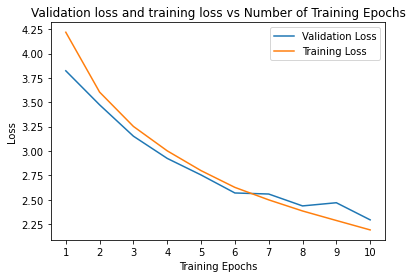

In [17]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [18]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.4447
train: correct, total = 22233,50000
val
Accuracy val: 0.4018
val: correct, total = 4018,10000


# Trial 2: Only Random Horizontal Flip

***In the below function for dataloaders, applying the following transformations on the training data for data augmentation.***

**Train Dataset**
1. Applying a Random Horizontal Flip with a probability of 50%.
2. Normalization of the training dataset (not part of data augmentation) for processing the data

**Validation Dataset**
1. Normalization of the validation dataset (not part of data augmentation) for processing the data

In [10]:
# creating a function for getting training data CIFAR100

def give_me_train_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a train dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    # defining the transformations on the train data
    
    transformations = [transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)]
    transform_train = transforms.Compose(transformations)
    
    train_set = CIFAR100('./data/cifar100', train=True, 
                         download=True, transform=transform_train)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = bs,
                                               shuffle=True, num_workers=num_workers)
    return train_loader

def give_me_test_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a test dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    
    # defining transformations on the test data
    
    transformations = [transforms.ToTensor(), transforms.Normalize(mean, std)]
    transform_test = transforms.Compose(transformations)
    
    valid_set = CIFAR100('./data/cifar100', train=False,
                  download=True, transform=transform_test)
    val_loader = torch.utils.data.DataLoader(valid_set, batch_size=bs, shuffle=False, 
                                             num_workers=num_workers)
    return val_loader

In [11]:
device = 'cuda'
model = SimpleNet()
model.to(device) # sending our model to gpu.

SimpleNet(
  (layer1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mxpool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear1): Linear(in_features=256, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=100, bias=True)
)

In [12]:
# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           4,864
         MaxPool2d-2             [-1, 64, 8, 8]               0
            Conv2d-3            [-1, 128, 4, 4]         204,928
         MaxPool2d-4            [-1, 128, 3, 3]               0
            Conv2d-5            [-1, 256, 2, 2]         819,456
         MaxPool2d-6            [-1, 256, 1, 1]               0
            Linear-7                 [-1, 1024]         263,168
            Linear-8                 [-1, 1024]       1,049,600
            Linear-9                  [-1, 100]         102,500
Total params: 2,444,516
Trainable params: 2,444,516
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 9.33
Estimated Total Size (MB): 9.54
---------------------------------------

In [13]:
# Preparing our data loaders for training and test.
# Batch size is 128 (tried 256 and 512, 128 gives better performance)

train_loader = give_me_train_data(bs = 128, num_workers=4, shuffle=True)
val_loader = give_me_test_data(bs = 128, num_workers=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [15]:
model.apply(init_weights)

SimpleNet(
  (layer1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mxpool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear1): Linear(in_features=256, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=100, bias=True)
)

In [16]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 4.1149 Acc: 0.0733
val Loss: 3.6723 Acc: 0.1401

Epoch 2/10
----------
train Loss: 3.4135 Acc: 0.1807
val Loss: 3.2225 Acc: 0.2201

Epoch 3/10
----------
train Loss: 3.0047 Acc: 0.2525
val Loss: 2.8795 Acc: 0.2807

Epoch 4/10
----------
train Loss: 2.7054 Acc: 0.3100
val Loss: 2.6700 Acc: 0.3183

Epoch 5/10
----------
train Loss: 2.4603 Acc: 0.3583
val Loss: 2.5243 Acc: 0.3576

Epoch 6/10
----------
train Loss: 2.2636 Acc: 0.4010
val Loss: 2.4194 Acc: 0.3758

Epoch 7/10
----------
train Loss: 2.1007 Acc: 0.4366
val Loss: 2.3195 Acc: 0.3948

Epoch 8/10
----------
train Loss: 1.9474 Acc: 0.4736
val Loss: 2.2728 Acc: 0.4115

Epoch 9/10
----------
train Loss: 1.8143 Acc: 0.5036
val Loss: 2.2970 Acc: 0.4160

Epoch 10/10
----------
train Loss: 1.6865 Acc: 0.5324
val Loss: 2.1545 Acc: 0.4409

Training complete in 1m 54s
Best val Acc: 0.440900


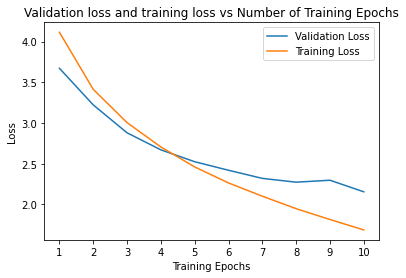

In [17]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [18]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.5948
train: correct, total = 29739,50000
val
Accuracy val: 0.4409
val: correct, total = 4409,10000


# Trial 3: Only Random Rotation

***In the below function for dataloaders, applying the following transformations on the training data for data augmentation.***

**Train Dataset**
1. Applying Random Rotation with the rotation angle of -15 to +15 degrees
2. Normalization of the training dataset (not part of data augmentation) for processing the data

**Validation Dataset**
1. Normalization of the validation dataset (not part of data augmentation) for processing the data

In [10]:
# creating a function for getting training data CIFAR100

def give_me_train_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a train dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    # defining the transformations on the train data
    
    transformations = [transforms.RandomRotation(15),
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)]
    transform_train = transforms.Compose(transformations)
    
    train_set = CIFAR100('./data/cifar100', train=True, 
                         download=True, transform=transform_train)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = bs,
                                               shuffle=True, num_workers=num_workers)
    return train_loader

def give_me_test_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a test dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    
    # defining transformations on the test data
    
#     transformations = [transforms.Resize(size=(227, 227)), transforms.CenterCrop(224), 
#                        transforms.ToTensor()]
    transformations = [transforms.ToTensor(), transforms.Normalize(mean, std)]
    transform_test = transforms.Compose(transformations)
    
    valid_set = CIFAR100('./data/cifar100', train=False,
                  download=True, transform=transform_test)
    val_loader = torch.utils.data.DataLoader(valid_set, batch_size=bs, shuffle=False, 
                                             num_workers=num_workers)
    return val_loader

In [11]:
device = 'cuda'
model = SimpleNet()
model.to(device) # sending our model to gpu.

# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           4,864
         MaxPool2d-2             [-1, 64, 8, 8]               0
            Conv2d-3            [-1, 128, 4, 4]         204,928
         MaxPool2d-4            [-1, 128, 3, 3]               0
            Conv2d-5            [-1, 256, 2, 2]         819,456
         MaxPool2d-6            [-1, 256, 1, 1]               0
            Linear-7                 [-1, 1024]         263,168
            Linear-8                 [-1, 1024]       1,049,600
            Linear-9                  [-1, 100]         102,500
Total params: 2,444,516
Trainable params: 2,444,516
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 9.33
Estimated Total Size (MB): 9.54
---------------------------------------

In [14]:
# Preparing our data loaders for training and test.
# Batch size is 128 (tried 256 and 512, 128 gives better performance)

train_loader = give_me_train_data(bs = 128, num_workers=4, shuffle=True)
val_loader = give_me_test_data(bs = 128, num_workers=4, shuffle=False)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

model.apply(init_weights)

Files already downloaded and verified
Files already downloaded and verified


SimpleNet(
  (layer1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mxpool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear1): Linear(in_features=256, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=100, bias=True)
)

In [15]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 4.1537 Acc: 0.0687
val Loss: 3.7631 Acc: 0.1292

Epoch 2/10
----------
train Loss: 3.4436 Acc: 0.1747
val Loss: 3.2635 Acc: 0.2074

Epoch 3/10
----------
train Loss: 3.0707 Acc: 0.2425
val Loss: 2.9611 Acc: 0.2661

Epoch 4/10
----------
train Loss: 2.8076 Acc: 0.2926
val Loss: 2.7949 Acc: 0.2962

Epoch 5/10
----------
train Loss: 2.6016 Acc: 0.3347
val Loss: 2.6430 Acc: 0.3303

Epoch 6/10
----------
train Loss: 2.4308 Acc: 0.3672
val Loss: 2.4957 Acc: 0.3619

Epoch 7/10
----------
train Loss: 2.2701 Acc: 0.4016
val Loss: 2.4548 Acc: 0.3707

Epoch 8/10
----------
train Loss: 2.1316 Acc: 0.4335
val Loss: 2.3983 Acc: 0.3850

Epoch 9/10
----------
train Loss: 1.9967 Acc: 0.4616
val Loss: 2.3464 Acc: 0.3980

Epoch 10/10
----------
train Loss: 1.8675 Acc: 0.4893
val Loss: 2.3660 Acc: 0.3994

Training complete in 1m 54s
Best val Acc: 0.399400


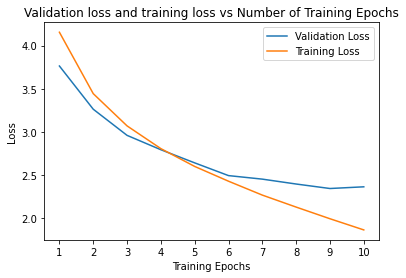

In [16]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [17]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.5294
train: correct, total = 26472,50000
val
Accuracy val: 0.3994
val: correct, total = 3994,10000


# Trial 4: With all transformations

***In the below function for dataloaders, applying the following transformations on the training data for data augmentation.***

**Train Dataset**
1. Applying a Random Crop of 3x32x32 with a padding of 4 on the original 3x32x32 image.
2. Applying a Random Horizontal Flip with a probability of 50%.
3. Applying Random Rotation with the rotation angle of -15 to +15 degrees
4. Normalization of the training dataset (not part of data augmentation) for processing the data

**Validation Dataset**
1. Normalization of the validation dataset (not part of data augmentation) for processing the data

In [6]:
# creating a function for getting training data CIFAR100

def give_me_train_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a train dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    # defining the transformations on the train data
    
    transformations = [transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.RandomRotation(15),
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)]
    transform_train = transforms.Compose(transformations)
    
    train_set = CIFAR100('./data/cifar100', train=True, 
                         download=True, transform=transform_train)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = bs,
                                               shuffle=True, num_workers=num_workers)
    return train_loader

def give_me_test_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a test dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    
    # defining transformations on the test data
    
#     transformations = [transforms.Resize(size=(227, 227)), transforms.CenterCrop(224), 
#                        transforms.ToTensor()]
    transformations = [transforms.ToTensor(), transforms.Normalize(mean, std)]
    transform_test = transforms.Compose(transformations)
    
    valid_set = CIFAR100('./data/cifar100', train=False,
                  download=True, transform=transform_test)
    val_loader = torch.utils.data.DataLoader(valid_set, batch_size=bs, shuffle=False, 
                                             num_workers=num_workers)
    return val_loader

In [12]:
device = 'cuda'
model = SimpleNet()
model.to(device) # sending our model to gpu.

# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           4,864
         MaxPool2d-2             [-1, 64, 8, 8]               0
            Conv2d-3            [-1, 128, 4, 4]         204,928
         MaxPool2d-4            [-1, 128, 3, 3]               0
            Conv2d-5            [-1, 256, 2, 2]         819,456
         MaxPool2d-6            [-1, 256, 1, 1]               0
            Linear-7                 [-1, 1024]         263,168
            Linear-8                 [-1, 1024]       1,049,600
            Linear-9                  [-1, 100]         102,500
Total params: 2,444,516
Trainable params: 2,444,516
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 9.33
Estimated Total Size (MB): 9.54
---------------------------------------

In [13]:
# Preparing our data loaders for training and test.
# Batch size is 128 (tried 256 and 512, 128 gives better performance)

train_loader = give_me_train_data(bs = 128, num_workers=4, shuffle=True)
val_loader = give_me_test_data(bs = 128, num_workers=4, shuffle=False)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

model.apply(init_weights)

Files already downloaded and verified
Files already downloaded and verified


SimpleNet(
  (layer1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mxpool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear1): Linear(in_features=256, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=100, bias=True)
)

In [14]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 4.2447 Acc: 0.0533
val Loss: 3.8404 Acc: 0.1062

Epoch 2/10
----------
train Loss: 3.6389 Acc: 0.1401
val Loss: 3.6302 Acc: 0.1396

Epoch 3/10
----------
train Loss: 3.3201 Acc: 0.1910
val Loss: 3.3238 Acc: 0.1935

Epoch 4/10
----------
train Loss: 3.1136 Acc: 0.2297
val Loss: 3.0891 Acc: 0.2369

Epoch 5/10
----------
train Loss: 2.9527 Acc: 0.2595
val Loss: 2.8775 Acc: 0.2774

Epoch 6/10
----------
train Loss: 2.8084 Acc: 0.2882
val Loss: 2.7876 Acc: 0.2958

Epoch 7/10
----------
train Loss: 2.6937 Acc: 0.3088
val Loss: 2.7124 Acc: 0.3117

Epoch 8/10
----------
train Loss: 2.5939 Acc: 0.3342
val Loss: 2.5489 Acc: 0.3433

Epoch 9/10
----------
train Loss: 2.5045 Acc: 0.3502
val Loss: 2.5571 Acc: 0.3449

Epoch 10/10
----------
train Loss: 2.4255 Acc: 0.3641
val Loss: 2.4415 Acc: 0.3657

Training complete in 1m 60s
Best val Acc: 0.365700


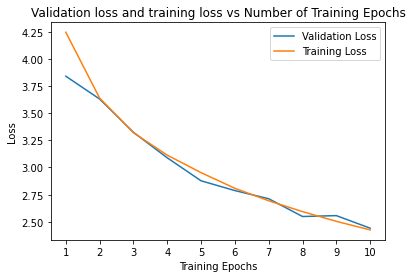

In [15]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [16]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.3919
train: correct, total = 19596,50000
val
Accuracy val: 0.3657
val: correct, total = 3657,10000
